In [1]:
## Importing libraries
import pandas as pd
import numpy as np
from tqdm import tqdm
tqdm.pandas()

In [2]:
match_lvl_data = pd.read_csv('/Users/alokroy/Documents/Programming/Projects/Amex/data/main/664389efa0868_match_level_scorecard.csv')
batsman_lvl_data = pd.read_csv('/Users/alokroy/Documents/Programming/Projects/Amex/data/main/663e2b548c98c_batsman_level_scorecard.csv')
bowler_lvl_data = pd.read_csv('/Users/alokroy/Documents/Programming/Projects/Amex/data/main/663e2b2c60743_bowler_level_scorecard.csv')
train_data = pd.read_csv('/Users/alokroy/Documents/Programming/Projects/Amex/data/main/663e2b6d54457_train_data_with_samplefeatures.csv')
test_data = pd.read_csv('/Users/alokroy/Documents/Programming/Projects/Amex/data/main/6644a1e287df6_test_data_with_samplefeatures.csv')

In [3]:
## Creating a binary winner column - 0 if team1 wins, else 1
train_data['winner_01'] = train_data.apply(lambda x: 0 if (x['team1']==x['winner']) else 1, axis=1)

In [4]:
def giveLastNgamesPlayer(player_id, date, n, bat_or_bowl):
    '''
    Function to get last n games stats of a player before an input date.

    Input-
    1. player_id: id of the player to get historical data.
    2. date: date to look-back and get n games. Stats returned are before this input date.
    3. n: Number of historical games stats to return.
    4. bat_or_bowl: Kind of stats to return. {'bat': batting stats to return, 'bowl': bowling stats to return}

    Output-None

    Returns- dataframe having bowling/batting stats from last n games of a player before an input date.
    The results are sorted by date.
    '''
    if bat_or_bowl == 'bat':
        df_topick = batsman_lvl_data
        id_col = 'batsman_id'
    else:
        df_topick = bowler_lvl_data
        id_col = 'bowler_id'

    return df_topick[(df_topick['match_dt']<date)&(df_topick[id_col]==float(player_id))]\
                .sort_values(by='match_dt', ascending=False).head(n)

In [5]:
def calculate_ratio(row, col1, col2):
    value1 = row[col1]
    value2 = row[col2]
    if value2 == 0:
        return value1
    else:
        return value1 / value2

# Function to add a ratio column for any two columns
def add_ratio_column(df, col1, col2, new_col_name):
    df[new_col_name] = df.apply(lambda row: calculate_ratio(row, col1, col2), axis=1)
    return df

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import pandas as pd

def check_distribution_match(train_feature, test_feature):
    """
    Checks and visualizes if the distributions of a feature in the train and test datasets match.

    Args:
    train_feature (pd.Series): Feature data from the training dataset.
    test_feature (pd.Series): Feature data from the testing dataset.
    """

    # Visualizing distributions with histograms
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.hist(train_feature, bins=30, alpha=0.5, color='blue', label='Train', density=True)
    plt.hist(test_feature, bins=30, alpha=0.5, color='red', label='Test', density=True)
    plt.legend(loc='upper right')
    plt.title('Histogram Comparison')

    # Density plot comparison
    plt.subplot(1, 2, 2)
    sns.kdeplot(train_feature, label='Train', fill=True, color='blue')
    sns.kdeplot(test_feature, label='Test', fill=True, color='red')
    plt.legend()
    plt.title('Density Plot Comparison')
    plt.tight_layout()
    plt.show()

    # Statistical test - Kolmogorov-Smirnov Test
    ks_stat, ks_pvalue = stats.ks_2samp(train_feature, test_feature)
    print(f"Kolmogorov-Smirnov test result: KS statistic = {ks_stat:.4f}, p-value = {ks_pvalue:.4f}")

    # Additional insights from descriptive statistics
    compare_stats = pd.DataFrame({
        'Train Stats': train_feature.describe(),
        'Test Stats': test_feature.describe()
    })
    print("\nDescriptive Statistics Comparison:")
    print(compare_stats)

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import re

# Set seaborn style
sns.set(style="whitegrid")

def createRnP(X_12, feature, N=5, ylim_lb=0.3, ylim_ub=0.7):
    '''
    Rank and Plot of input feature on the input data. The y-axis shows %team1 wins in each bucket.
    
    Parameters-
    1. X_12: dataset to build the RnP on. 
    2. feature: Feature to build RnP of.
    3. N: number of bins on x-axis. Default 5.
    4. ylim_lb: lower bound of y axis on plot.
    5. ylim_ub: upper bound of y axis on plot.
    
    Output-
    1. Rank and Plot
    
    Returns- None
    '''
    df = X_12.copy()
    df[f'{feature}_bin'] = df[feature].rank(pct=True)//(1/N) # divide feature values for all games in 5 equi-volume buckets.
    df['count'] = 1
    df['team1_win%'] = df['winner_01'].apply(lambda x: 1-x) # invert winner_01 to get team1 winner indicator
    df['team2_win%'] = df['winner_01'].copy()
    df[f'{feature}_min'] = df[feature].copy()
    df[f'{feature}_max'] = df[feature].copy()
    df_g = df.groupby(f'{feature}_bin').agg({'team1_win%':'mean', 'team2_win%':'mean', 'count':'sum', f'{feature}_min':'min',\
                                            f'{feature}_max':'max'}).reset_index()
    N = min(N,df_g.shape[0])
    blue_bar = df_g['team1_win%'].values.tolist()
    ind = np.arange(N)
    # plotting starts
    plt.figure(figsize=(10,5));
    plt.bar(ind, blue_bar, label='Team 1 win%');
    plt.axhline(y=0.5, linewidth=0.5, color='k', linestyle = '--')
    xlabel = re.sub('team_','ratio_',feature)
    plt.xlabel(f'{xlabel} (team1 / team2) bins');
    plt.ylabel('Win %');
    plt.title(f'RnP - {feature} vs win');
    df_g['xticks'] = df_g.apply(lambda x: str(round(x[f'{feature}_min'],2)) + ' - ' + str(round(x[f'{feature}_max'],2)), axis=1)
    plt.xticks(ind, df_g['xticks']);
    plt.ylim([ylim_lb,ylim_ub]);
    plt.legend(loc='best');
    x2,x1 = blue_bar[-1],blue_bar[0]
    slope = x2/x1
    if slope < 1:
        slope = 1/slope
        x1,x2 = x2,x1
    print('slope:', round(x2,2),'/',round(x1,2), '= ',round(slope,2))
    plt.show();
    
    correlation = df['winner_01'].corr(df[feature])
    print(f"Correlation between {feature} and winner_01 is: {correlation}") 

## Features

1

In [8]:
num_matches = 25

In [9]:
def avg_wickets_top5_bowlers(bowler_df, team_roster_ids, date, n=10):
    team_ids = team_roster_ids.split(':')
    bowlers_wickets = []

    for player_id in team_ids:
        recent_matches = giveLastNgamesPlayer(player_id, date, n, 'bowl')
        if not recent_matches.empty:
            total_wickets = recent_matches['wicket_count'].sum()
            bowlers_wickets.append(total_wickets)

    bowlers_wickets.sort(reverse=True)
    top5_bowlers_wickets = bowlers_wickets[:5]

    return sum(top5_bowlers_wickets) / 5 if len(top5_bowlers_wickets) == 5 else sum(top5_bowlers_wickets) / len(top5_bowlers_wickets) if len(top5_bowlers_wickets) > 0 else 0

In [10]:
train_data['team1_avg_wickets_top5_bowlers'] = train_data.apply(lambda x: avg_wickets_top5_bowlers(bowler_lvl_data, x['team1_roster_ids'], x['match_dt'],n=num_matches), axis=1)
train_data['team2_avg_wickets_top5_bowlers'] = train_data.apply(lambda x: avg_wickets_top5_bowlers(bowler_lvl_data, x['team2_roster_ids'], x['match_dt'],n=num_matches), axis=1)

train_data = add_ratio_column(train_data, 'team1_avg_wickets_top5_bowlers', 'team2_avg_wickets_top5_bowlers', 'team_avg_wickets_top5_bowlers')

train_data = train_data.drop(columns=['team1_avg_wickets_top5_bowlers', 'team2_avg_wickets_top5_bowlers'])

test_data['team1_avg_wickets_top5_bowlers'] = test_data.apply(lambda x: avg_wickets_top5_bowlers(bowler_lvl_data, x['team1_roster_ids'], x['match_dt'],n=num_matches), axis=1)
test_data['team2_avg_wickets_top5_bowlers'] = test_data.apply(lambda x: avg_wickets_top5_bowlers(bowler_lvl_data, x['team2_roster_ids'], x['match_dt'],n=num_matches), axis=1)

test_data = add_ratio_column(test_data, 'team1_avg_wickets_top5_bowlers', 'team2_avg_wickets_top5_bowlers', 'team_avg_wickets_top5_bowlers')

test_data = test_data.drop(columns=['team1_avg_wickets_top5_bowlers', 'team2_avg_wickets_top5_bowlers'])

slope: 0.61 / 0.32 =  1.91


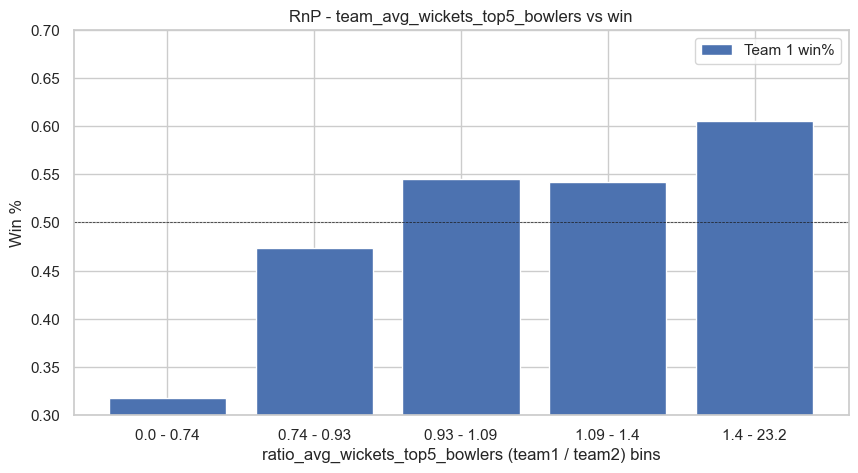

Correlation between team_avg_wickets_top5_bowlers and winner_01 is: -0.13498264895765738


In [11]:
createRnP(train_data, 'team_avg_wickets_top5_bowlers')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


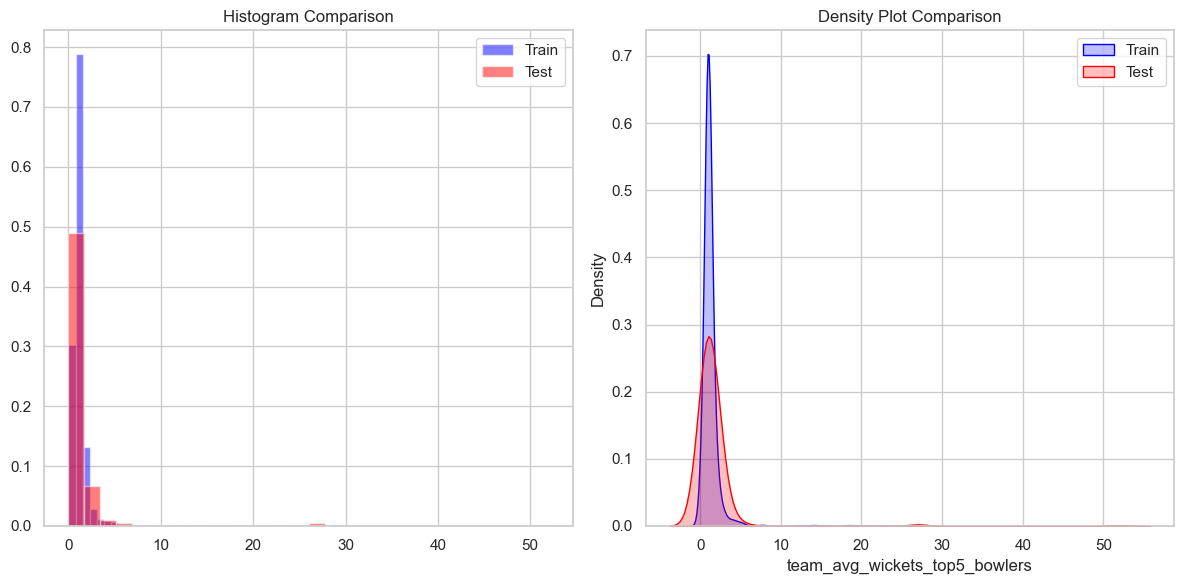

Kolmogorov-Smirnov test result: KS statistic = 0.0629, p-value = 0.3568

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      1.244052    1.564994
std       1.481775    3.859753
min       0.000000    0.000000
25%       0.792256    0.830157
50%       1.010110    1.033613
75%       1.296547    1.334040
max      23.200000   52.000000


In [12]:
check_distribution_match(train_data['team_avg_wickets_top5_bowlers'], test_data['team_avg_wickets_top5_bowlers'])

2.

In [13]:
def bowling_strike_rate(player_list, date, n=10):
    player_ids = player_list.split(':')
    total_balls = 0
    total_wickets = 0

    for player_id in player_ids:
        recent_matches = giveLastNgamesPlayer(player_id, date, n, bat_or_bowl='bowl')
        total_balls += recent_matches['balls_bowled'].sum()
        total_wickets += recent_matches['wicket_count'].sum()

    return total_balls / total_wickets if total_wickets > 0 else 0


In [14]:
train_data['team1_bowling_strike_rate'] = train_data.apply(lambda x: bowling_strike_rate(x['team1_roster_ids'], x['match_dt'], n=num_matches), axis=1)
train_data['team2_bowling_strike_rate'] = train_data.apply(lambda x: bowling_strike_rate(x['team2_roster_ids'], x['match_dt'], n=num_matches), axis=1)

train_data = add_ratio_column(train_data, 'team1_bowling_strike_rate', 'team2_bowling_strike_rate', 'team_bowling_strike_rate')

train_data = train_data.drop(columns=['team1_bowling_strike_rate', 'team2_bowling_strike_rate'])

test_data['team1_bowling_strike_rate'] = test_data.apply(lambda x: bowling_strike_rate(x['team1_roster_ids'], x['match_dt'], n=num_matches), axis=1)
test_data['team2_bowling_strike_rate'] = test_data.apply(lambda x: bowling_strike_rate(x['team2_roster_ids'], x['match_dt'], n=num_matches), axis=1)

test_data = add_ratio_column(test_data, 'team1_bowling_strike_rate', 'team2_bowling_strike_rate', 'team_bowling_strike_rate')

test_data = test_data.drop(columns=['team1_bowling_strike_rate', 'team2_bowling_strike_rate'])


slope: 0.48 / 0.48 =  1.01


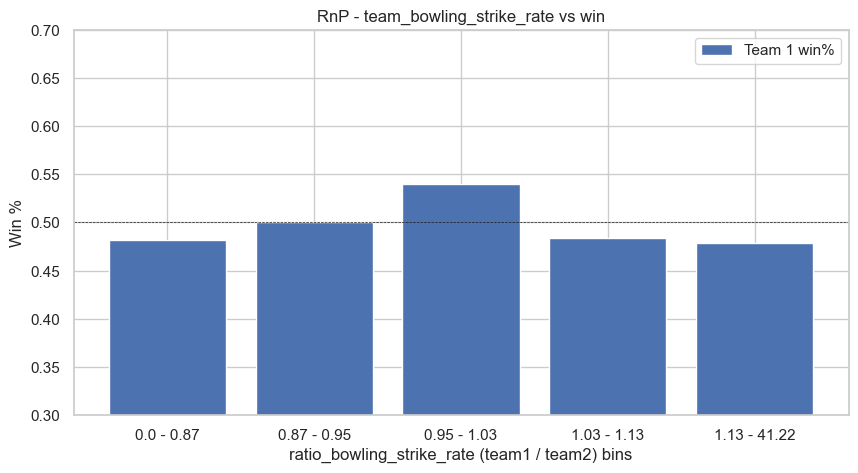

Correlation between team_bowling_strike_rate and winner_01 is: -0.008734474162691932


In [15]:
createRnP(train_data, 'team_bowling_strike_rate')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


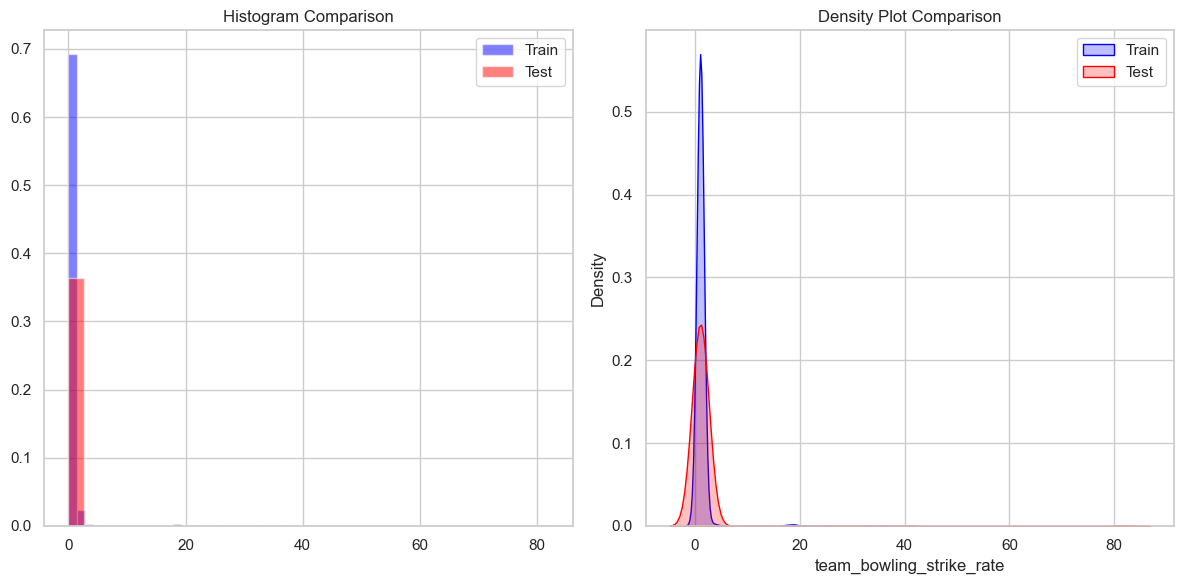

Kolmogorov-Smirnov test result: KS statistic = 0.0826, p-value = 0.1054

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      1.260437    1.303225
std       2.590002    4.927023
min       0.000000    0.000000
25%       0.893981    0.885873
50%       0.994312    0.997734
75%       1.104474    1.118741
max      41.222222   82.000000


In [16]:
check_distribution_match(train_data['team_bowling_strike_rate'], test_data['team_bowling_strike_rate'])

3.

In [17]:
def economy_rate_against_top_teams(player_list, date, n=10):
    player_ids = player_list.split(':')
    total_runs = 0
    total_balls = 0

    for player_id in player_ids:
        recent_matches = giveLastNgamesPlayer(player_id, date, n, bat_or_bowl='bowl')
        recent_matches_top_teams = recent_matches
        total_runs += recent_matches_top_teams['runs'].sum()
        total_balls += recent_matches_top_teams['balls_bowled'].sum()

    return (total_runs * 6) / total_balls if total_balls > 0 else 0


In [18]:
train_data['team1_economy_rate_against_top_teams'] = train_data.apply(lambda x: economy_rate_against_top_teams(x['team1_roster_ids'], x['match_dt'], n = num_matches), axis=1)
train_data['team2_economy_rate_against_top_teams'] = train_data.apply(lambda x: economy_rate_against_top_teams(x['team2_roster_ids'], x['match_dt'], n = num_matches), axis=1)

train_data = add_ratio_column(train_data, 'team1_economy_rate_against_top_teams', 'team2_economy_rate_against_top_teams', 'team_economy_rate_against_top_teams')

train_data = train_data.drop(columns=['team1_economy_rate_against_top_teams', 'team2_economy_rate_against_top_teams'])

test_data['team1_economy_rate_against_top_teams'] = test_data.apply(lambda x: economy_rate_against_top_teams(x['team1_roster_ids'], x['match_dt'], n = num_matches), axis=1)
test_data['team2_economy_rate_against_top_teams'] = test_data.apply(lambda x: economy_rate_against_top_teams(x['team2_roster_ids'], x['match_dt'], n = num_matches), axis=1)

test_data = add_ratio_column(test_data, 'team1_economy_rate_against_top_teams', 'team2_economy_rate_against_top_teams', 'team_economy_rate_against_top_teams')

test_data = test_data.drop(columns=['team1_economy_rate_against_top_teams', 'team2_economy_rate_against_top_teams'])

slope: 0.49 / 0.43 =  1.13


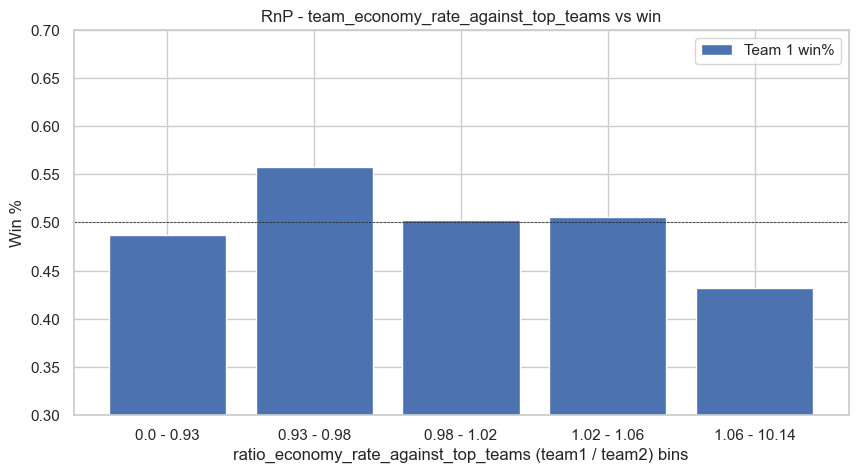

Correlation between team_economy_rate_against_top_teams and winner_01 is: -0.0387975929880374


In [19]:
createRnP(train_data, 'team_economy_rate_against_top_teams')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


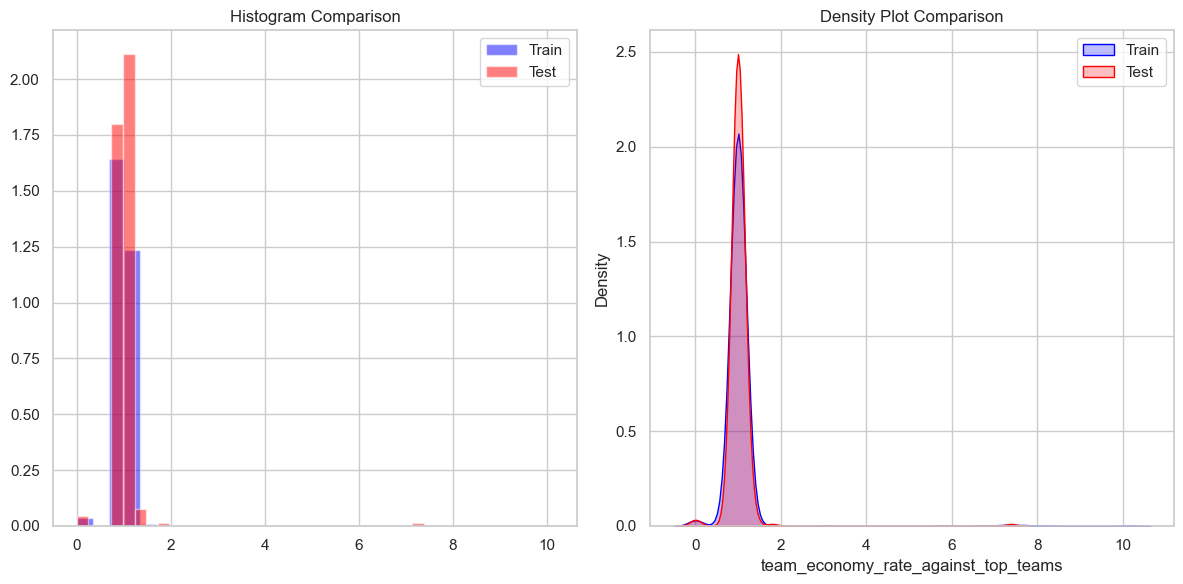

Kolmogorov-Smirnov test result: KS statistic = 0.0519, p-value = 0.5998

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      1.052288    1.019694
std       0.664532    0.414315
min       0.000000    0.000000
25%       0.948011    0.951353
50%       0.998521    0.989850
75%       1.046044    1.045424
max      10.136519    7.390244


In [20]:
check_distribution_match(train_data['team_economy_rate_against_top_teams'], test_data['team_economy_rate_against_top_teams'])

4.

In [21]:
def maiden_over_frequency(bowler_df, player_list, date, n=10):
    player_ids = player_list.split(':')
    total_maidens = 0
    total_matches = 0

    for player_id in player_ids:
        player_id = float(player_id)
        recent_matches = giveLastNgamesPlayer(player_id, date, n, bat_or_bowl='bowl')
        total_maidens += recent_matches['maiden'].sum()
        total_matches += len(recent_matches)

    return total_maidens / total_matches if total_matches > 0 else 0


In [22]:
train_data['team1_maiden_over_frequency'] = train_data.apply(lambda x: maiden_over_frequency(bowler_lvl_data, x['team1_roster_ids'], x['match_dt'],n = num_matches), axis=1)
train_data['team2_maiden_over_frequency'] = train_data.apply(lambda x: maiden_over_frequency(bowler_lvl_data, x['team2_roster_ids'], x['match_dt'],n = num_matches), axis=1)

train_data = add_ratio_column(train_data, 'team1_maiden_over_frequency', 'team2_maiden_over_frequency', 'team_maiden_over_frequency')

train_data = train_data.drop(columns=['team1_maiden_over_frequency', 'team2_maiden_over_frequency'])

test_data['team1_maiden_over_frequency'] = test_data.apply(lambda x: maiden_over_frequency(bowler_lvl_data, x['team1_roster_ids'], x['match_dt'],n = num_matches), axis=1)
test_data['team2_maiden_over_frequency'] = test_data.apply(lambda x: maiden_over_frequency(bowler_lvl_data, x['team2_roster_ids'], x['match_dt'],n = num_matches), axis=1)

test_data = add_ratio_column(test_data, 'team1_maiden_over_frequency', 'team2_maiden_over_frequency', 'team_maiden_over_frequency')

test_data = test_data.drop(columns=['team1_maiden_over_frequency', 'team2_maiden_over_frequency'])

slope: 0.51 / 0.44 =  1.14


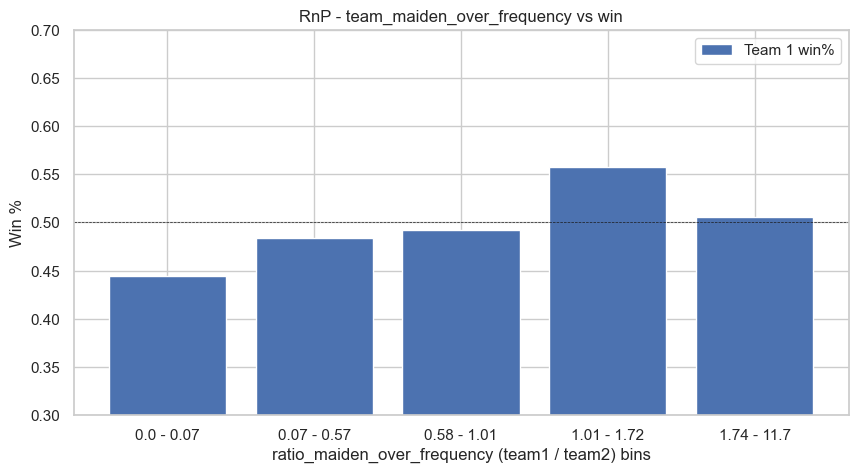

Correlation between team_maiden_over_frequency and winner_01 is: -0.028901463729575454


In [23]:
createRnP(train_data, 'team_maiden_over_frequency')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


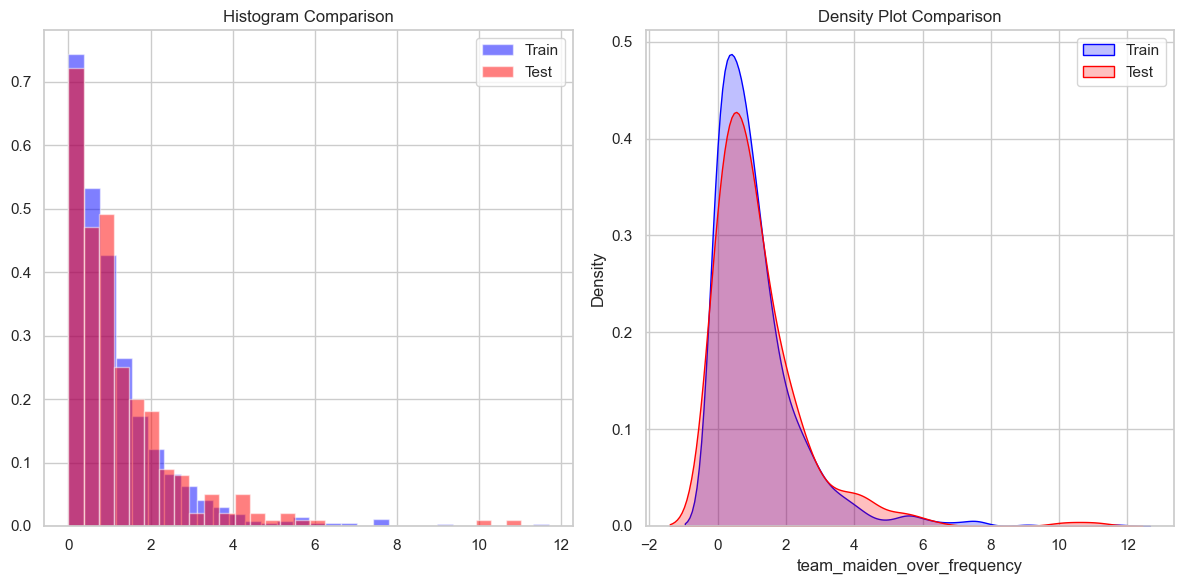

Kolmogorov-Smirnov test result: KS statistic = 0.0468, p-value = 0.7223

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      1.104948    1.211737
std       1.259858    1.430737
min       0.000000    0.000000
25%       0.277512    0.316938
50%       0.783638    0.825000
75%       1.489016    1.675952
max      11.700000   11.034483


In [24]:
check_distribution_match(train_data['team_maiden_over_frequency'], test_data['team_maiden_over_frequency'])

5.

In [25]:
def dot_ball_percentage(bowler_df, player_list, date, n=10):
    player_ids = player_list.split(':')
    total_dots = 0
    total_balls = 0

    for player_id in player_ids:
        player_id = float(player_id)
        recent_matches = giveLastNgamesPlayer(player_id, date, n, bat_or_bowl='bowl')
        total_dots += recent_matches['dots'].sum()
        total_balls += recent_matches['balls_bowled'].sum()

    return (total_dots / total_balls * 100) if total_balls > 0 else 0

In [26]:
train_data['team1_dot_ball_percentage'] = train_data.apply(lambda x: dot_ball_percentage(bowler_lvl_data, x['team1_roster_ids'], x['match_dt'],n = num_matches), axis=1)
train_data['team2_dot_ball_percentage'] = train_data.apply(lambda x: dot_ball_percentage(bowler_lvl_data, x['team2_roster_ids'], x['match_dt'],n = num_matches), axis=1)

train_data = add_ratio_column(train_data, 'team1_dot_ball_percentage', 'team2_dot_ball_percentage', 'team_dot_ball_percentage')

train_data = train_data.drop(columns=['team1_dot_ball_percentage', 'team2_dot_ball_percentage'])

test_data['team1_dot_ball_percentage'] = test_data.apply(lambda x: dot_ball_percentage(bowler_lvl_data, x['team1_roster_ids'], x['match_dt'],n = num_matches), axis=1)
test_data['team2_dot_ball_percentage'] = test_data.apply(lambda x: dot_ball_percentage(bowler_lvl_data, x['team2_roster_ids'], x['match_dt'],n = num_matches), axis=1)

test_data = add_ratio_column(test_data, 'team1_dot_ball_percentage', 'team2_dot_ball_percentage', 'team_dot_ball_percentage')

test_data = test_data.drop(columns=['team1_dot_ball_percentage', 'team2_dot_ball_percentage'])

slope: 0.49 / 0.42 =  1.16


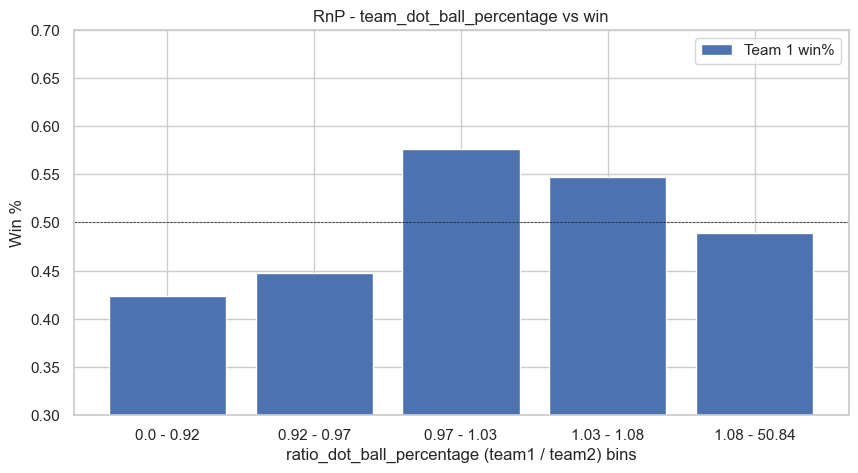

Correlation between team_dot_ball_percentage and winner_01 is: -0.03707736357491628


In [27]:
createRnP(train_data, 'team_dot_ball_percentage')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


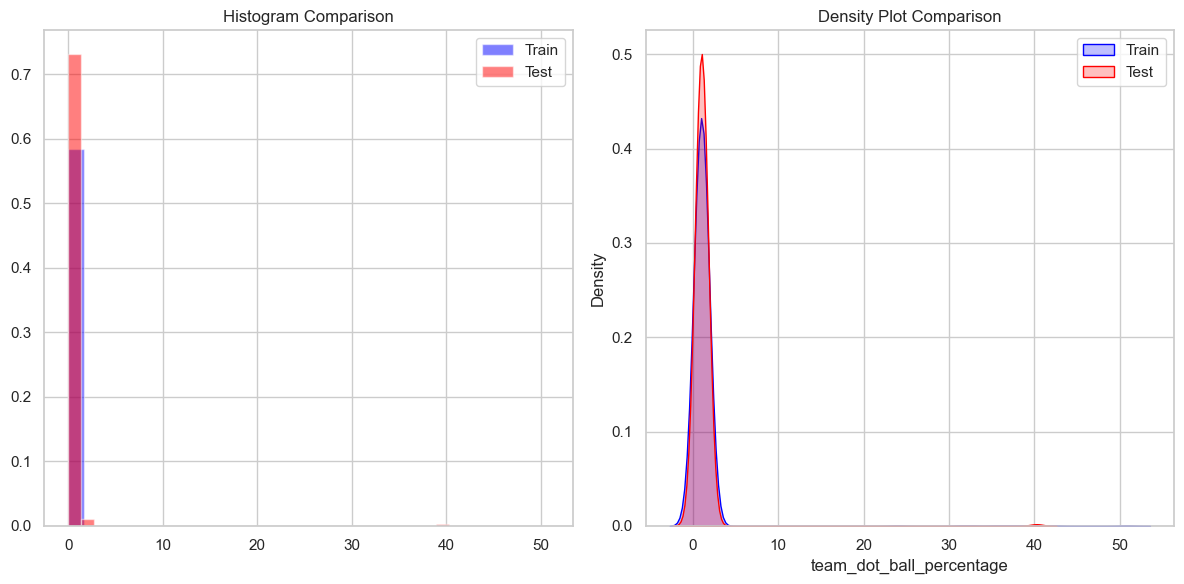

Kolmogorov-Smirnov test result: KS statistic = 0.0361, p-value = 0.9357

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      1.336127    1.147982
std       3.547948    2.389326
min       0.000000    0.000000
25%       0.935917    0.936378
50%       1.004355    1.004462
75%       1.067582    1.068047
max      50.841751   40.243902


In [28]:
check_distribution_match(train_data['team_dot_ball_percentage'], test_data['team_dot_ball_percentage'])

6.

In [29]:
def extra_runs_conceded(bowler_df, player_list, date, n=10):
    player_ids = player_list.split(':')
    total_extras = 0

    for player_id in player_ids:
        player_id = float(player_id)
        recent_matches = giveLastNgamesPlayer(player_id, date, n, bat_or_bowl='bowl')
        total_extras += recent_matches['wides'].sum() + recent_matches['noballs'].sum()

    return total_extras

In [30]:
train_data['team1_extra_runs_conceded'] = train_data.apply(lambda x: extra_runs_conceded(bowler_lvl_data, x['team1_roster_ids'], x['match_dt'],n = num_matches), axis=1)
train_data['team2_extra_runs_conceded'] = train_data.apply(lambda x: extra_runs_conceded(bowler_lvl_data, x['team2_roster_ids'], x['match_dt'],n = num_matches), axis=1)

train_data = add_ratio_column(train_data, 'team1_extra_runs_conceded', 'team2_extra_runs_conceded', 'team_extra_runs_conceded')

train_data = train_data.drop(columns=['team1_extra_runs_conceded', 'team2_extra_runs_conceded'])

test_data['team1_extra_runs_conceded'] = test_data.apply(lambda x: extra_runs_conceded(bowler_lvl_data, x['team1_roster_ids'], x['match_dt'],n = num_matches), axis=1)
test_data['team2_extra_runs_conceded'] = test_data.apply(lambda x: extra_runs_conceded(bowler_lvl_data, x['team2_roster_ids'], x['match_dt'],n = num_matches), axis=1)

test_data = add_ratio_column(test_data, 'team1_extra_runs_conceded', 'team2_extra_runs_conceded', 'team_extra_runs_conceded')

test_data = test_data.drop(columns=['team1_extra_runs_conceded', 'team2_extra_runs_conceded'])

slope: 0.53 / 0.4 =  1.34


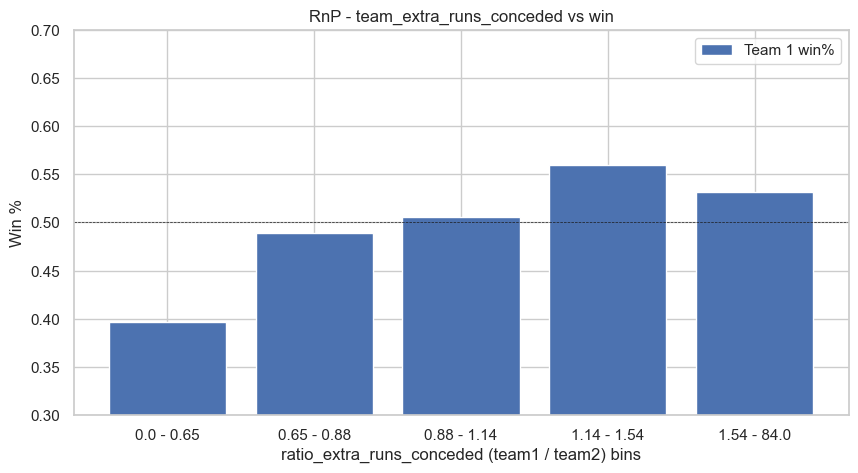

Correlation between team_extra_runs_conceded and winner_01 is: -0.08107185737696726


In [31]:
createRnP(train_data, 'team_extra_runs_conceded')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


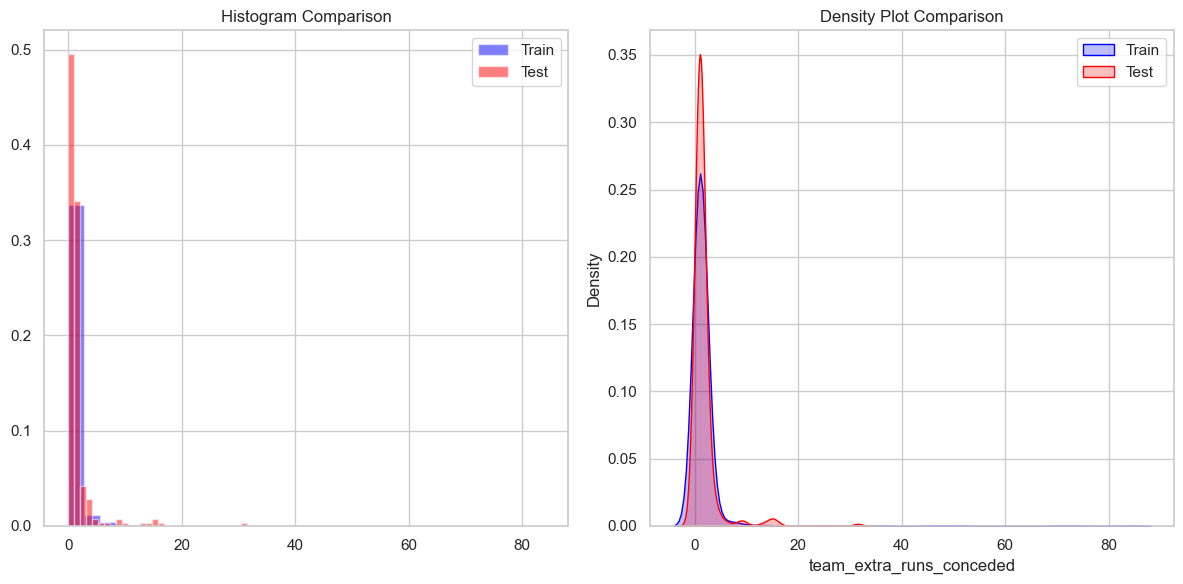

Kolmogorov-Smirnov test result: KS statistic = 0.0395, p-value = 0.8817

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      1.704927    1.634670
std       5.328558    2.823597
min       0.000000    0.000000
25%       0.714286    0.709588
50%       1.000000    1.018182
75%       1.410324    1.414170
max      84.000000   31.500000


In [32]:
check_distribution_match(train_data['team_extra_runs_conceded'], test_data['team_extra_runs_conceded'])

7.

In [33]:
def boundary_control_score(bowler_df, player_list, date, n=10):
    player_ids = player_list.split(':')
    total_balls = 0
    boundary_balls = 0

    for player_id in player_ids:
        player_id = float(player_id)
        recent_matches = giveLastNgamesPlayer(player_id, date, n, bat_or_bowl='bowl')
        total_balls += recent_matches['balls_bowled'].sum()
        boundary_balls += recent_matches['Fours'].sum() + recent_matches['Sixes'].sum()

    return (boundary_balls / total_balls * 100) if total_balls > 0 else 0


In [34]:
train_data['team1_boundary_control_score'] = train_data.apply(lambda x: boundary_control_score(bowler_lvl_data, x['team1_roster_ids'], x['match_dt'],n = num_matches), axis=1)
train_data['team2_boundary_control_score'] = train_data.apply(lambda x: boundary_control_score(bowler_lvl_data, x['team2_roster_ids'], x['match_dt'],n = num_matches), axis=1)

train_data = add_ratio_column(train_data, 'team1_boundary_control_score', 'team2_boundary_control_score', 'team_boundary_control_score')

train_data = train_data.drop(columns=['team1_boundary_control_score', 'team2_boundary_control_score'])

test_data['team1_boundary_control_score'] = test_data.apply(lambda x: boundary_control_score(bowler_lvl_data, x['team1_roster_ids'], x['match_dt'],n = num_matches), axis=1)
test_data['team2_boundary_control_score'] = test_data.apply(lambda x: boundary_control_score(bowler_lvl_data, x['team2_roster_ids'], x['match_dt'],n = num_matches), axis=1)

test_data = add_ratio_column(test_data, 'team1_boundary_control_score', 'team2_boundary_control_score', 'team_boundary_control_score')

test_data = test_data.drop(columns=['team1_boundary_control_score', 'team2_boundary_control_score'])

slope: 0.49 / 0.48 =  1.02


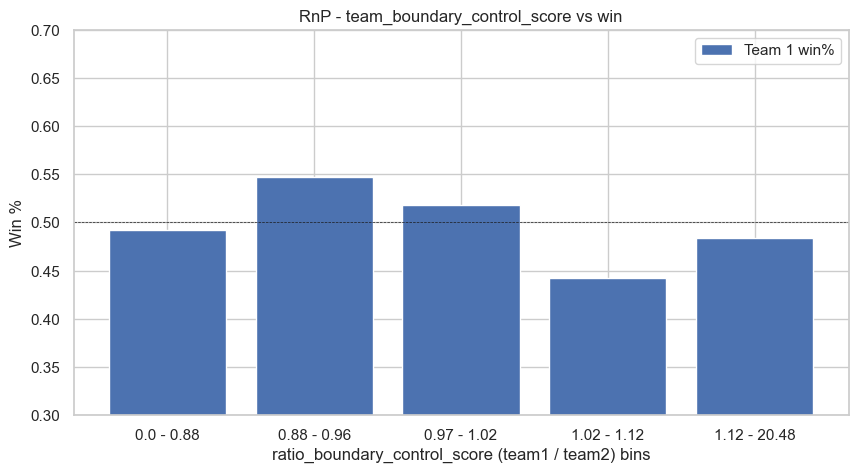

Correlation between team_boundary_control_score and winner_01 is: -0.0338679122855702


In [35]:
createRnP(train_data, 'team_boundary_control_score')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


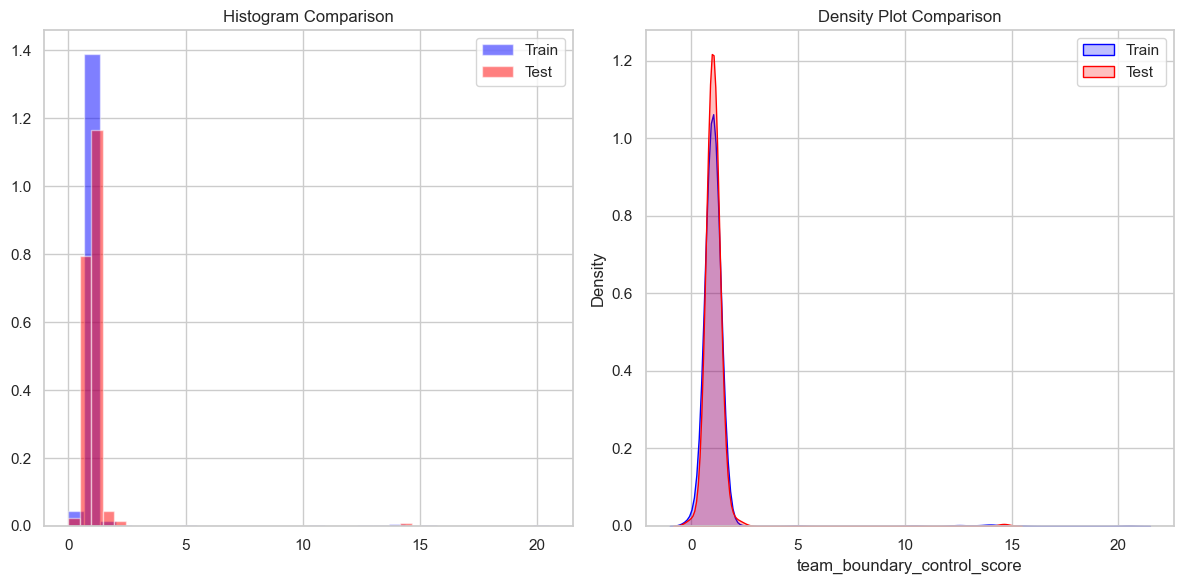

Kolmogorov-Smirnov test result: KS statistic = 0.0403, p-value = 0.8668

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      1.121722    1.068194
std       1.316323    0.856762
min       0.000000    0.000000
25%       0.909086    0.916532
50%       0.996089    1.003326
75%       1.093941    1.097905
max      20.477816   14.634146


In [36]:
check_distribution_match(train_data['team_boundary_control_score'], test_data['team_boundary_control_score'])

8.

In [37]:
def average_wickets_per_match(player_list, date, n=10):
    player_ids = player_list.split(':')
    total_wickets = 0
    total_matches = 0

    for player_id in player_ids:
        player_id = float(player_id)
        recent_matches = giveLastNgamesPlayer(player_id, date, n, bat_or_bowl='bowl')
        total_wickets += recent_matches['wicket_count'].sum()
        total_matches += len(recent_matches)

    return total_wickets / total_matches if total_matches > 0 else 0


In [38]:
train_data['team1_average_wickets_per_match'] = train_data.apply(lambda x: average_wickets_per_match(x['team1_roster_ids'], x['match_dt'],n = num_matches), axis=1)
train_data['team2_average_wickets_per_match'] = train_data.apply(lambda x: average_wickets_per_match(x['team2_roster_ids'], x['match_dt'],n = num_matches), axis=1)

train_data = add_ratio_column(train_data, 'team1_average_wickets_per_match', 'team2_average_wickets_per_match', 'team_average_wickets_per_match')

train_data = train_data.drop(columns=['team1_average_wickets_per_match', 'team2_average_wickets_per_match'])

test_data['team1_average_wickets_per_match'] = test_data.apply(lambda x: average_wickets_per_match(x['team1_roster_ids'], x['match_dt'],n = num_matches), axis=1)
test_data['team2_average_wickets_per_match'] = test_data.apply(lambda x: average_wickets_per_match(x['team2_roster_ids'], x['match_dt'],n = num_matches), axis=1)

test_data = add_ratio_column(test_data, 'team1_average_wickets_per_match', 'team2_average_wickets_per_match', 'team_average_wickets_per_match')

test_data = test_data.drop(columns=['team1_average_wickets_per_match', 'team2_average_wickets_per_match'])

slope: 0.52 / 0.46 =  1.13


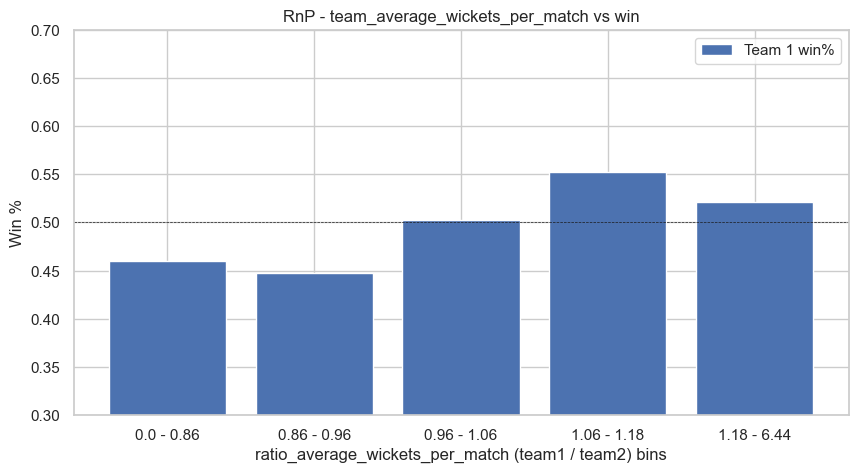

Correlation between team_average_wickets_per_match and winner_01 is: -0.10495632320619461


In [39]:
createRnP(train_data, 'team_average_wickets_per_match')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


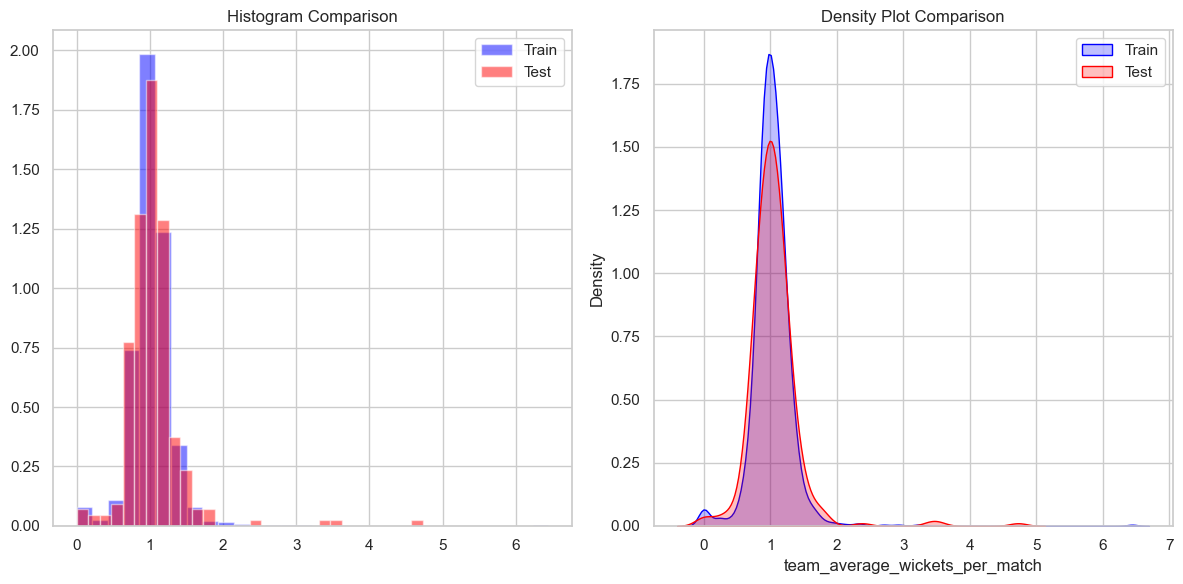

Kolmogorov-Smirnov test result: KS statistic = 0.0626, p-value = 0.3607

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      1.024265    1.044372
std       0.331409    0.412996
min       0.000000    0.000000
25%       0.886871    0.862133
50%       1.009092    0.999280
75%       1.152341    1.171609
max       6.444444    4.727273


In [40]:
check_distribution_match(train_data['team_average_wickets_per_match'], test_data['team_average_wickets_per_match'])

9.

In [41]:
def average_economy_rate(player_list, date, n=10):
    player_ids = player_list.split(':')
    total_runs = 0
    total_balls = 0

    for player_id in player_ids:
        player_id = float(player_id)
        recent_matches = giveLastNgamesPlayer(player_id, date, n, bat_or_bowl='bowl')
        total_runs += recent_matches['runs'].sum()
        total_balls += recent_matches['balls_bowled'].sum()

    return (total_runs / (total_balls / 6)) if total_balls > 0 else 0

In [42]:
train_data['team1_average_economy_rate'] = train_data.apply(lambda x: average_economy_rate(x['team1_roster_ids'], x['match_dt'],n = num_matches), axis=1)
train_data['team2_average_economy_rate'] = train_data.apply(lambda x: average_economy_rate(x['team2_roster_ids'], x['match_dt'],n = num_matches), axis=1)

train_data = add_ratio_column(train_data, 'team1_average_economy_rate', 'team2_average_economy_rate', 'team_average_economy_rate')

train_data = train_data.drop(columns=['team1_average_economy_rate', 'team2_average_economy_rate'])

test_data['team1_average_economy_rate'] = test_data.apply(lambda x: average_economy_rate(x['team1_roster_ids'], x['match_dt'],n = num_matches), axis=1)
test_data['team2_average_economy_rate'] = test_data.apply(lambda x: average_economy_rate(x['team2_roster_ids'], x['match_dt'],n = num_matches), axis=1)

test_data = add_ratio_column(test_data, 'team1_average_economy_rate', 'team2_average_economy_rate', 'team_average_economy_rate')

test_data = test_data.drop(columns=['team1_average_economy_rate', 'team2_average_economy_rate'])

slope: 0.49 / 0.43 =  1.13


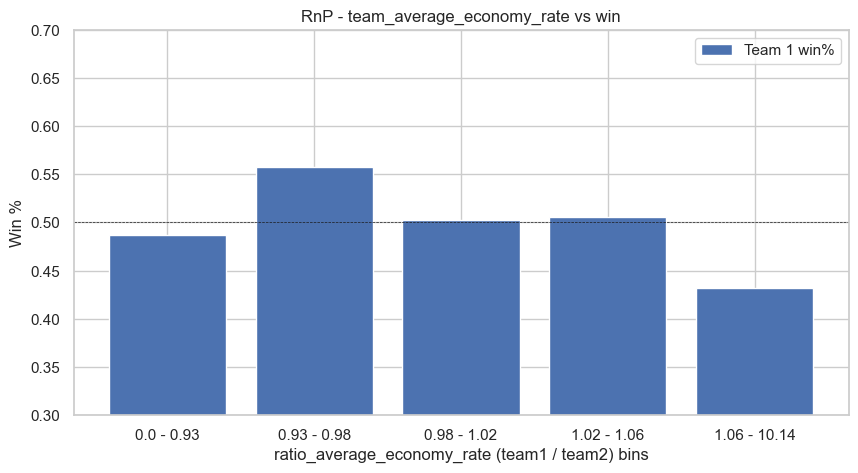

Correlation between team_average_economy_rate and winner_01 is: -0.038797592988037394


In [43]:
createRnP(train_data, 'team_average_economy_rate')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


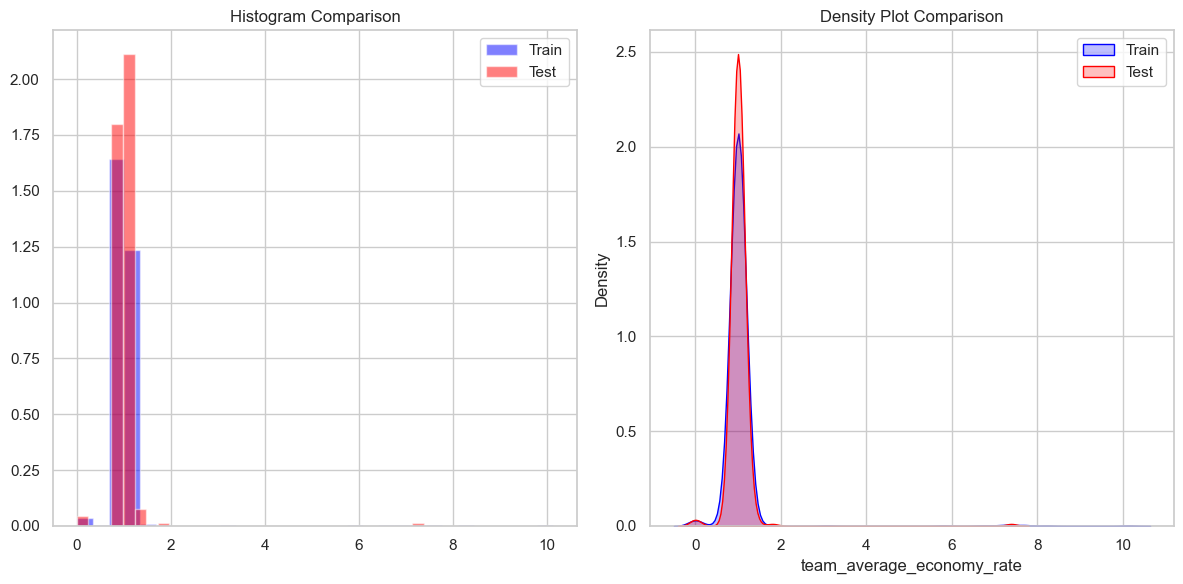

Kolmogorov-Smirnov test result: KS statistic = 0.0519, p-value = 0.5998

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      1.052288    1.019694
std       0.664532    0.414315
min       0.000000    0.000000
25%       0.948011    0.951353
50%       0.998521    0.989850
75%       1.046044    1.045424
max      10.136519    7.390244


In [44]:
check_distribution_match(train_data['team_average_economy_rate'], test_data['team_average_economy_rate'])

10.

In [45]:
def average_dots_per_match(player_list, date, n=10):
    player_ids = player_list.split(':')
    total_dots = 0
    total_matches = 0

    for player_id in player_ids:
        player_id = float(player_id)
        recent_matches = giveLastNgamesPlayer(player_id, date, n, bat_or_bowl='bowl')
        total_dots += recent_matches['dots'].sum()
        total_matches += len(recent_matches)

    return total_dots / total_matches if total_matches > 0 else 0


In [46]:
train_data['team1_average_dots_per_match'] = train_data.apply(lambda x: average_dots_per_match(x['team1_roster_ids'], x['match_dt'],n = num_matches), axis=1)
train_data['team2_average_dots_per_match'] = train_data.apply(lambda x: average_dots_per_match(x['team2_roster_ids'], x['match_dt'],n = num_matches), axis=1)

train_data = add_ratio_column(train_data, 'team1_average_dots_per_match', 'team2_average_dots_per_match', 'team_average_dots_per_match')

train_data = train_data.drop(columns=['team1_average_dots_per_match', 'team2_average_dots_per_match'])

test_data['team1_average_dots_per_match'] = test_data.apply(lambda x: average_dots_per_match(x['team1_roster_ids'], x['match_dt'],n = num_matches), axis=1)
test_data['team2_average_dots_per_match'] = test_data.apply(lambda x: average_dots_per_match(x['team2_roster_ids'], x['match_dt'],n = num_matches), axis=1)

test_data = add_ratio_column(test_data, 'team1_average_dots_per_match', 'team2_average_dots_per_match', 'team_average_dots_per_match')

test_data = test_data.drop(columns=['team1_average_dots_per_match', 'team2_average_dots_per_match'])

slope: 0.53 / 0.41 =  1.3


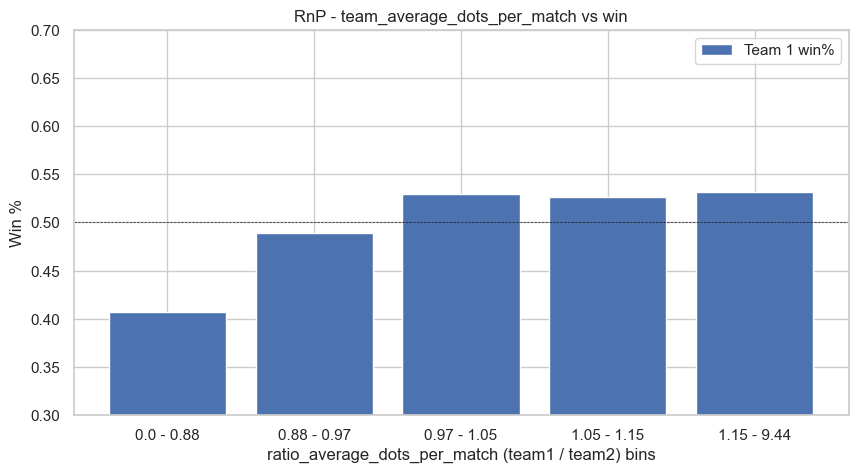

Correlation between team_average_dots_per_match and winner_01 is: -0.07077544376240767


In [47]:
createRnP(train_data, 'team_average_dots_per_match')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


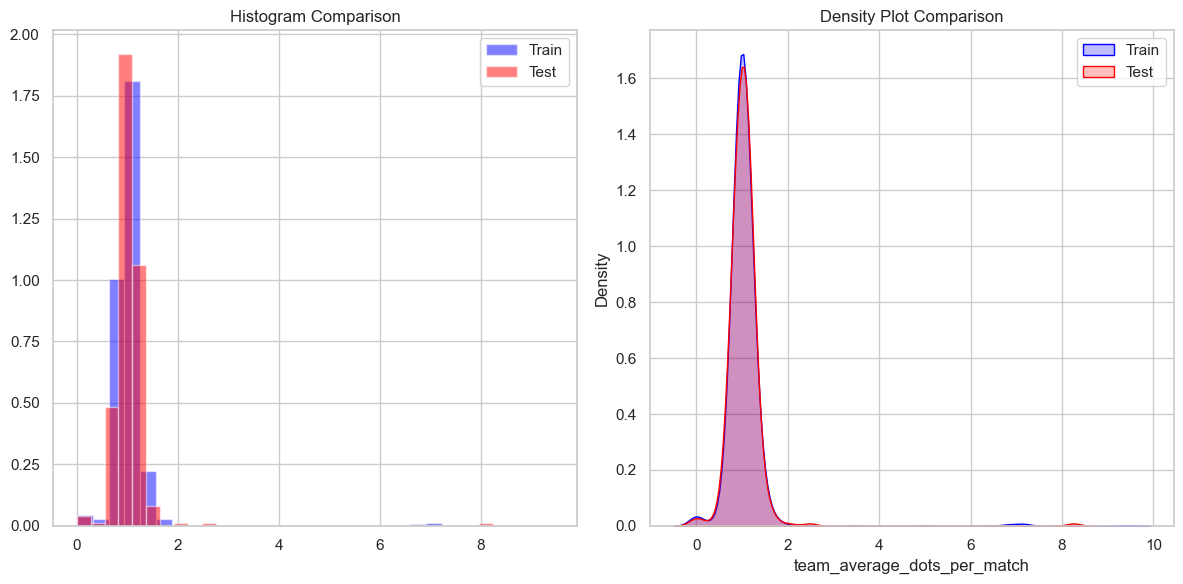

Kolmogorov-Smirnov test result: KS statistic = 0.0783, p-value = 0.1409

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      1.071044    1.041603
std       0.645023    0.498289
min       0.000000    0.000000
25%       0.904338    0.890051
50%       1.009629    1.025654
75%       1.116831    1.127982
max       9.437500    8.250000


In [48]:
check_distribution_match(train_data['team_average_dots_per_match'], test_data['team_average_dots_per_match'])

11.

In [49]:
def average_extras_per_match(player_list, date, n=10):
    player_ids = player_list.split(':')
    total_extras = 0
    total_matches = 0

    for player_id in player_ids:
        player_id = float(player_id)
        recent_matches = giveLastNgamesPlayer(player_id, date, n, bat_or_bowl='bowl')
        total_extras += recent_matches['wides'].sum() + recent_matches['noballs'].sum()
        total_matches += len(recent_matches)

    return total_extras / total_matches if total_matches > 0 else 0


In [50]:
train_data['team1_average_extras_per_match'] = train_data.apply(lambda x: average_extras_per_match(x['team1_roster_ids'], x['match_dt'],n = num_matches), axis=1)
train_data['team2_average_extras_per_match'] = train_data.apply(lambda x: average_extras_per_match(x['team2_roster_ids'], x['match_dt'],n = num_matches), axis=1)

train_data = add_ratio_column(train_data, 'team1_average_extras_per_match', 'team2_average_extras_per_match', 'team_average_extras_per_match')

train_data = train_data.drop(columns=['team1_average_extras_per_match', 'team2_average_extras_per_match'])

test_data['team1_average_extras_per_match'] = test_data.apply(lambda x: average_extras_per_match(x['team1_roster_ids'], x['match_dt'],n = num_matches), axis=1)
test_data['team2_average_extras_per_match'] = test_data.apply(lambda x: average_extras_per_match(x['team2_roster_ids'], x['match_dt'],n = num_matches), axis=1)

test_data = add_ratio_column(test_data, 'team1_average_extras_per_match', 'team2_average_extras_per_match', 'team_average_extras_per_match')

test_data = test_data.drop(columns=['team1_average_extras_per_match', 'team2_average_extras_per_match'])

slope: 0.51 / 0.43 =  1.19


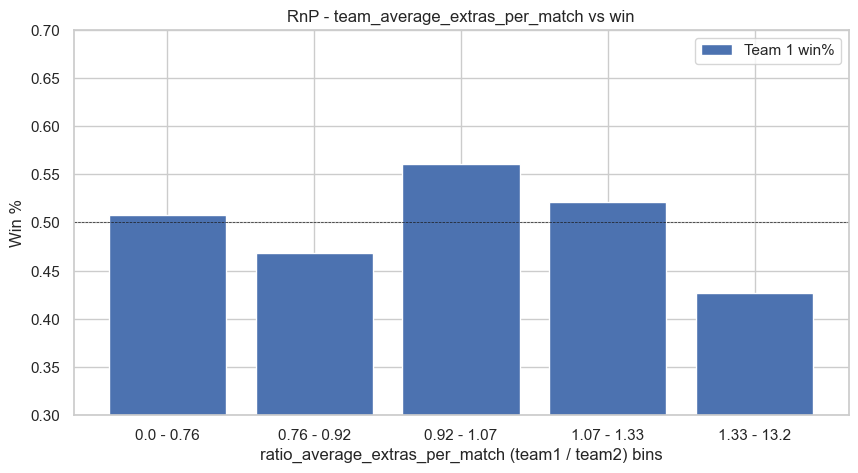

Correlation between team_average_extras_per_match and winner_01 is: -0.012543065553119327


In [51]:
createRnP(train_data, 'team_average_extras_per_match')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


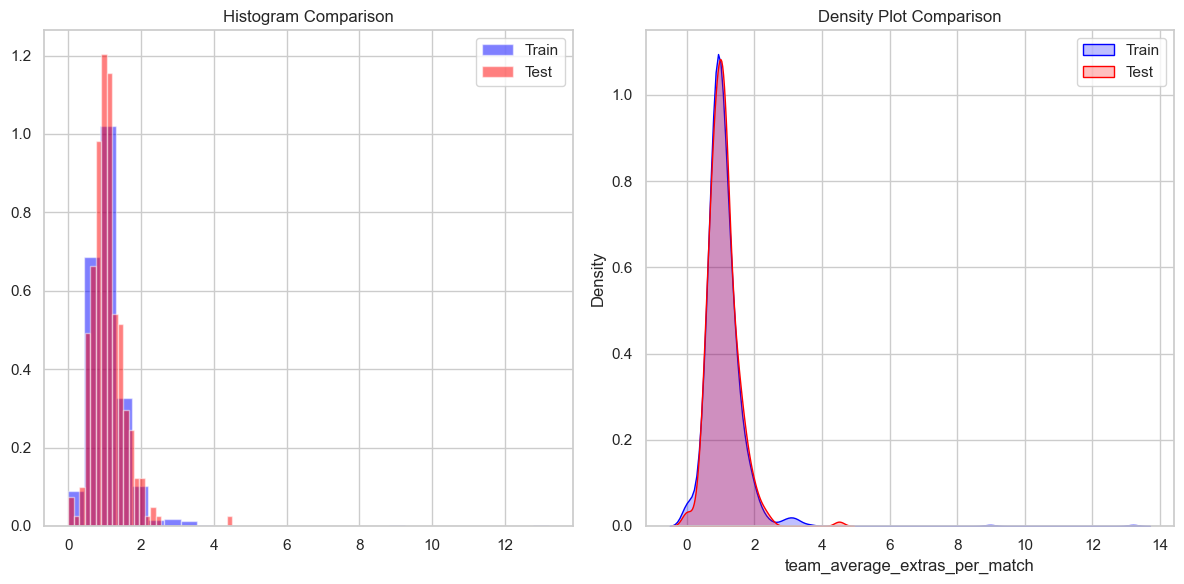

Kolmogorov-Smirnov test result: KS statistic = 0.0625, p-value = 0.3659

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      1.082972    1.076020
std       0.657799    0.449497
min       0.000000    0.000000
25%       0.799555    0.799580
50%       0.985741    1.025885
75%       1.254133    1.250968
max      13.200000    4.505172


In [52]:
check_distribution_match(train_data['team_average_extras_per_match'], test_data['team_average_extras_per_match'])

12.

In [53]:
def boundary_control_efficiency(player_list, date, n=10):
    player_ids = player_list.split(':')
    total_boundaries = 0
    total_overs = 0

    for player_id in player_ids:
        player_id = float(player_id)
        recent_matches = giveLastNgamesPlayer(player_id, date, n, bat_or_bowl='bowl')
        total_boundaries += recent_matches['Fours'].sum() + recent_matches['Sixes'].sum()
        total_overs += recent_matches['balls_bowled'].sum() / 6

    return total_boundaries / total_overs if total_overs > 0 else 0


In [54]:
train_data['team1_boundary_control_efficiency'] = train_data.apply(lambda x: boundary_control_efficiency(x['team1_roster_ids'], x['match_dt'],n = num_matches), axis=1)
train_data['team2_boundary_control_efficiency'] = train_data.apply(lambda x: boundary_control_efficiency(x['team2_roster_ids'], x['match_dt'],n = num_matches), axis=1)

train_data = add_ratio_column(train_data, 'team1_boundary_control_efficiency', 'team2_boundary_control_efficiency', 'team_boundary_control_efficiency')

train_data = train_data.drop(columns=['team1_boundary_control_efficiency', 'team2_boundary_control_efficiency'])

test_data['team1_boundary_control_efficiency'] = test_data.apply(lambda x: boundary_control_efficiency(x['team1_roster_ids'], x['match_dt'],n = num_matches), axis=1)
test_data['team2_boundary_control_efficiency'] = test_data.apply(lambda x: boundary_control_efficiency(x['team2_roster_ids'], x['match_dt'],n = num_matches), axis=1)

test_data = add_ratio_column(test_data, 'team1_boundary_control_efficiency', 'team2_boundary_control_efficiency', 'team_boundary_control_efficiency')

test_data = test_data.drop(columns=['team1_boundary_control_efficiency', 'team2_boundary_control_efficiency'])

slope: 0.51 / 0.48 =  1.07


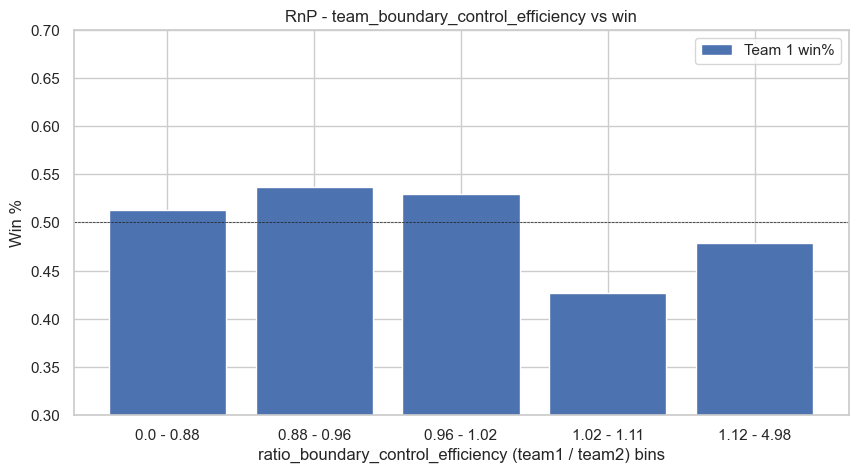

Correlation between team_boundary_control_efficiency and winner_01 is: -0.03163784730037739


In [55]:
createRnP(train_data, 'team_boundary_control_efficiency')

/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/homebrew/Caskroom/miniforge/base/envs/amex/lib/python3.12/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


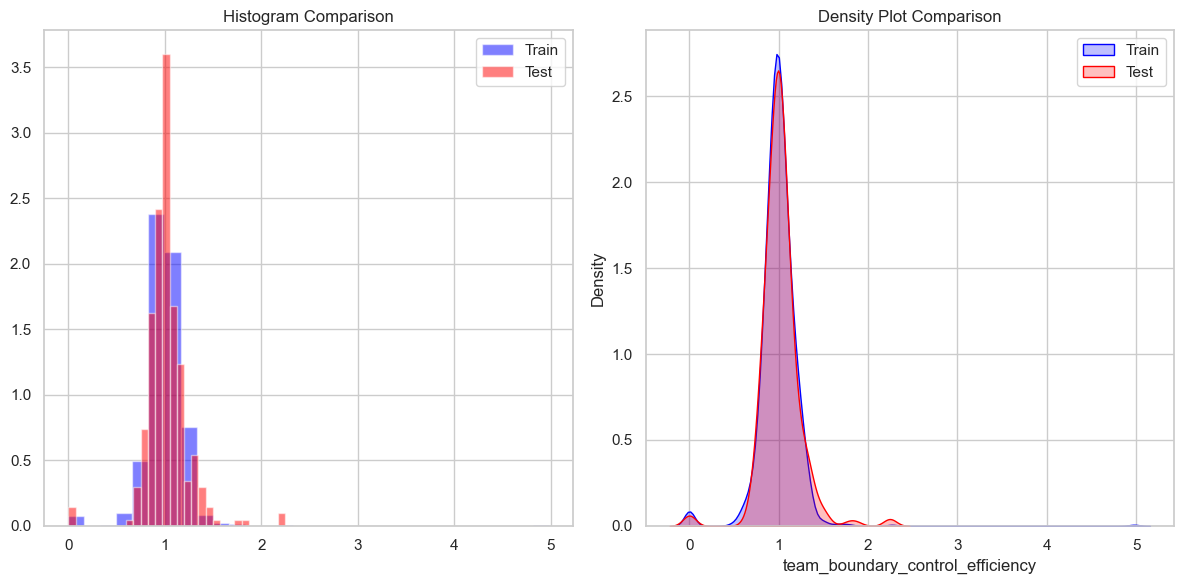

Kolmogorov-Smirnov test result: KS statistic = 0.0458, p-value = 0.7455

Descriptive Statistics Comparison:
       Train Stats  Test Stats
count   948.000000  271.000000
mean      0.995973    1.017434
std       0.232752    0.223555
min       0.000000    0.000000
25%       0.907212    0.915306
50%       0.993661    1.002242
75%       1.089362    1.094032
max       4.977169    2.244189


In [56]:
check_distribution_match(train_data['team_boundary_control_efficiency'], test_data['team_boundary_control_efficiency'])